## Imports and read in as before

In [30]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

############# read training and test data from the files #############
X_train = pd.read_csv("X_train.csv").to_numpy()
X_train = X_train[:,1:]  #remove the id column
y_train = pd.read_csv("y_train.csv").to_numpy()
y_train = y_train[:,1]
X_test = pd.read_csv("X_test.csv").to_numpy()
X_test = X_test[:,1:]  #remove the id column

X_train0 = X_train
y_train0 = y_train
X_test0 = X_test

## Removal of redundant features as before

In [31]:
# first remove features with very low variance
normalized_std_threshold = 0.001
normalized_std = np.zeros(X_train.shape[1])
means_abs = np.zeros(X_train.shape[1])
for i in range(X_train.shape[1]):
    vec = X_train[:,i]
    means_abs[i] = np.abs(np.mean(vec[~np.isnan(vec)])) + 1
    normalized_std[i] = np.std(vec[~np.isnan(vec)])/means_abs[i]

mask = np.ones(len(normalized_std), dtype=bool)
mask[normalized_std < normalized_std_threshold] = False

X_train = X_train[:, mask]
X_test = X_test[:, mask]

# Scaling as before and then after outlier rejection another imputation
### Imputation perhaps with MICE already

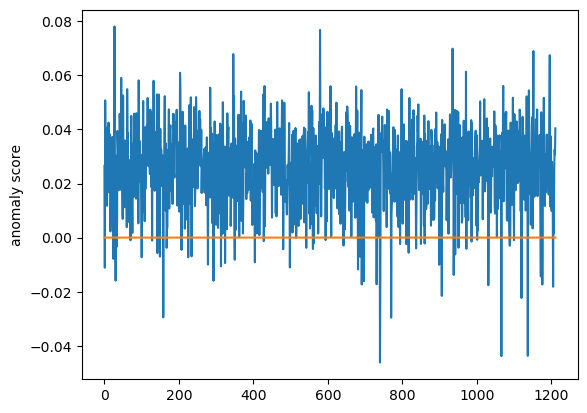

Size of training set after initial preprocessing: (1151, 773)


In [32]:
# # Scaling
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


############ Imputation1 #############
# imputer = KNNImputer(n_neighbors=50) 
# X_train_sc_imp0 = imputer.fit_transform(X_train_scaled)
# X_test_sc_imp0 = imputer.fit_transform(X_test_scaled)

Imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_simp_imp1 = Imputer.fit_transform(X_train_scaled)
X_test_simp_imp1 = Imputer.fit_transform(X_test_scaled)

############# Outlier detection: IsolationForest #############

outlier_det = IsolationForest(random_state=0, contamination=0.05, max_features=0.5).fit(X_train_simp_imp1)
anomaly_score = outlier_det.decision_function(X_train_simp_imp1)

### to determine the contamination parameter, I propose to first plot the anomaly score function and then decide on the
### the contamination ratio based on visual thresholding.
### HERE WE NEED TO VISUALLY DETERMINE A THRESHOLD:
anomaly_threshold = 0.0
plt.plot(anomaly_score)
plt.plot(np.ones(anomaly_score.shape)*anomaly_threshold)
plt.ylabel('anomaly score')
plt.show()

outliers=np.where(anomaly_score < anomaly_threshold)

inlier_flag1 = np.ones(len(anomaly_score), dtype=bool)
inlier_flag1[outliers[0]] = False
X_train_od1 = X_train_scaled[inlier_flag1,:]
y_train_od1 = y_train[inlier_flag1]

print('Size of training set after initial preprocessing:', X_train_od1.shape)

############ Imputation2 #############
# imputer = KNNImputer(n_neighbors=50) 
# X_train_sc_imp0 = imputer.fit_transform(X_train_scaled)
# X_test_sc_imp0 = imputer.fit_transform(X_test_scaled)
X_train_od12 = X_train_scaled[inlier_flag1,:]

Imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_simp_imp2 = Imputer.fit_transform(X_train_od12)



## Feature Selection

In [33]:
############# Feature selection using ExtraTreesRegressor #############
#Here X_train_simp_imp1 is double imputed with rejected outliers and y_train_od0 has its outliers removed as well.

selector = ExtraTreesRegressor(n_estimators=50, random_state=0, min_samples_split=0.02, max_samples=0.9, bootstrap=True)
selector = selector.fit(X_train_simp_imp2, y_train_od1)
selector.feature_importances_  

good_features = np.where(selector.feature_importances_ > 1e-3)[0]
print('number of selected features:', len(good_features))

number of selected features: 149


## Correlated Feature Removal

In [ ]:

# corr_threshold = 0.9

# corr_matrix = np.abs(np.corrcoef(X_train_cl0[:,support], rowvar=False))
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# corr_mat_triu = np.ma.masked_array(corr_matrix, mask=mask)

# # plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
# # plt.show()

# drop_features = [c for c in range(corr_mat_triu.shape[1]) if any(corr_mat_triu[:,c] > corr_threshold)]
# corr_mask = np.ones(corr_mat_triu.shape[1], dtype=bool)
# corr_mask[drop_features] = False
# support = support[corr_mask]

# Outlier Rejection and Data Imputation with relevant features
## Again Imputation -> Outlier Detection -> Imputation

In [35]:
# Imputation1 and building vectors for outlier detection 2
y_train_sel = y_train[inlier_flag1]

X_train_sel = X_train_scaled[:,good_features]
X_train_sel = X_train_sel[inlier_flag1]

imp_mean = IterativeImputer(random_state=0, n_nearest_features = None, sample_posterior = False, max_iter=100) 
X_train_sel = imp_mean.fit_transform(X_train_sel)


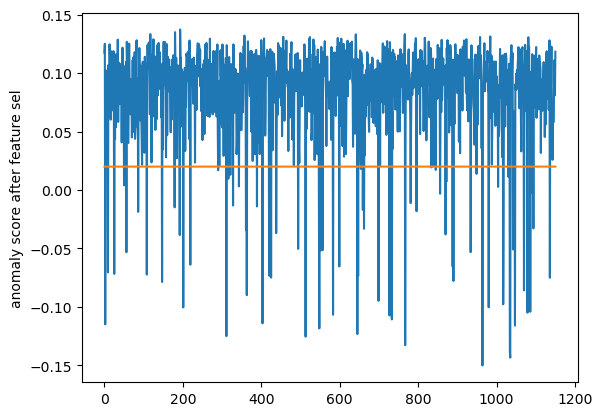

Shape of the training set: (1081, 149)


In [36]:
#Outlier Rejection 2:
#TODO: fix the argument inputs for the second round and run 
outlierdet = IsolationForest(random_state=0, contamination=0.05, max_features=0.5).fit(X_train_sel)
anomaly_score2 = outlierdet.decision_function(X_train_sel)

anomaly_threshold2 = 0.02
plt.plot(anomaly_score2)
plt.plot(np.ones(anomaly_score2.shape)*anomaly_threshold2)
plt.ylabel('anomaly score after feature sel')
plt.show()

outliers=np.where(anomaly_score2 < anomaly_threshold2)

inlier_flag2 = np.ones(len(anomaly_score2), dtype=bool)
inlier_flag2[outliers[0]] = False
X_train_od2 = X_train_sel[inlier_flag2,:]
y_train_od2 = y_train_sel[inlier_flag2]

print('Shape of the training set:', X_train_od2.shape)



In [37]:
#Imputation 2:
#############  #############
X_train_sel2 = X_train_scaled[:,good_features]
X_train_sel2 = X_train_sel2[inlier_flag1, :]
X_train_sel2 = X_train_sel2[inlier_flag2, :]

y_train_sel2 = y_train[inlier_flag1]
y_train_processed = y_train_sel2[inlier_flag2]

X_test_sel = X_test_scaled[:,good_features]

############# MICE imputation #############

imp_mean = IterativeImputer(random_state=0, n_nearest_features = None, sample_posterior = False, max_iter=100) 
X_train_processed = imp_mean.fit_transform(X_train_sel2)
X_test_processed = imp_mean.fit_transform(X_test_sel)

# Regression
## Regression models and combination thereof
### Just implement it differently than the vectorized approach
### What is this split between decision trees and the other methods?

In [38]:
############# Regression using a decision tree #############

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
reg_model = DecisionTreeRegressor(random_state=0, min_samples_split=0.01)
n_scores = cross_val_score(reg_model, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

run_list = [0,0,1,0,1]

############# Regression using a random forest #############
if run_list[0]:
    rf_reg = ExtraTreesRegressor(n_estimators=100, random_state=0, min_samples_split=5, max_samples=None)
    n_scores = cross_val_score(rf_reg, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('ExtraTrees: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    regressor = rf_reg.fit(X_train_processed, y_train_processed)
    y_predicted_rf = regressor.predict(X_test_processed)


############# Regression using HistGradientBoostingRegressor #############
if run_list[1]:
    HGB_reg = HistGradientBoostingRegressor(max_iter=200, learning_rate = 0.1, l2_regularization = 10)
    n_scores = cross_val_score(HGB_reg, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('HBG: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    regressor = HGB_reg.fit(X_train_processed, y_train_processed)
    y_predicted_hgb = regressor.predict(X_test_processed)

############# Regression using SVR #############
if run_list[2]:
    SVR_reg = SVR(kernel='rbf', degree=50, gamma=0.011, coef0=0.0, tol=0.1, C=100, epsilon=0.1, shrinking=True, cache_size=200)
    n_scores = cross_val_score(SVR_reg, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('SVR: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    regressor = SVR_reg.fit(X_train_processed, y_train_processed)
    y_predicted_svr = regressor.predict(X_test_processed)
    
############# Regression using adaboost #############
if run_list[3]:
    ada_regr = AdaBoostRegressor(random_state=0, n_estimators=1000, loss='square', learning_rate=0.5)
    n_scores = cross_val_score(ada_regr, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('Ada: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

############# Regression using MLP #############
if run_list[4]:
    MLP_reg = MLPRegressor(random_state=10, max_iter=10000,activation='tanh',solver='sgd',alpha=10, hidden_layer_sizes=(200))
    n_scores = cross_val_score(MLP_reg, X_train_processed, y_train_processed, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('MLP: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    regressor = MLP_reg.fit(X_train_processed, y_train_processed)
    y_predicted_mlp = regressor.predict(X_test_processed)


MAE: 0.184 (0.130)
SVR: 0.641 (0.045)
MLP: 0.612 (0.055)


# Evaluate Predictions and write to file


In [39]:
############# Write out the predictions to a csv file #############
y_predicted = 1/2*(y_predicted_svr + y_predicted_mlp)
d = {'id': range(len(y_predicted)), 'y': y_predicted}
y_predicted_df = pd.DataFrame(data=d)
y_predicted_df.to_csv("AMLES_submission_v61.csv", index=False)